# Price Forecast Model

This notebook contains the exploratory data analysis, model training, and evaluation steps for the price forecasting model.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style='whitegrid')

In [20]:
# Load the dataset
df = pd.read_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\data\SAFEX_wheat_friday_df.csv')

# Display the first few rows of the dataset
df.head()

,Date,Price,volume,open_price,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,Price_diff,year_month,max_temp,precipitation,avg_temp,min_temp,active_flag,day
0,2015-03-27,3800.0,139.0,3780.0,12.0438,507.75,512.00,2634.0,2422.0,5.0,201503.0,79.0489,2.195833,68.6914,58.31695,0,Friday
1,2015-04-03,3800.0,1.0,3800.0,11.9878,528.50,529.50,2608.0,2422.0,-30.0,201504.0,73.7244,0.994166,62.3620,50.99110,1,Friday
2,2015-04-10,3800.0,1.0,3800.0,11.9878,528.50,529.50,2608.0,2422.0,-30.0,201504.0,73.7244,0.994166,62.3620,50.99110,1,Friday
3,2015-04-17,3700.0,15.0,3705.0,12.0675,494.50,489.25,2557.0,2379.0,-40.0,201504.0,73.7244,0.994166,62.3620,50.99110,0,Friday
4,2015-04-24,3790.0,205.0,3750.0,12.1222,486.00,488.50,2576.0,2384.0,57.0,201504.0,73.7244,0.994166,62.3620,50.99110,0,Friday


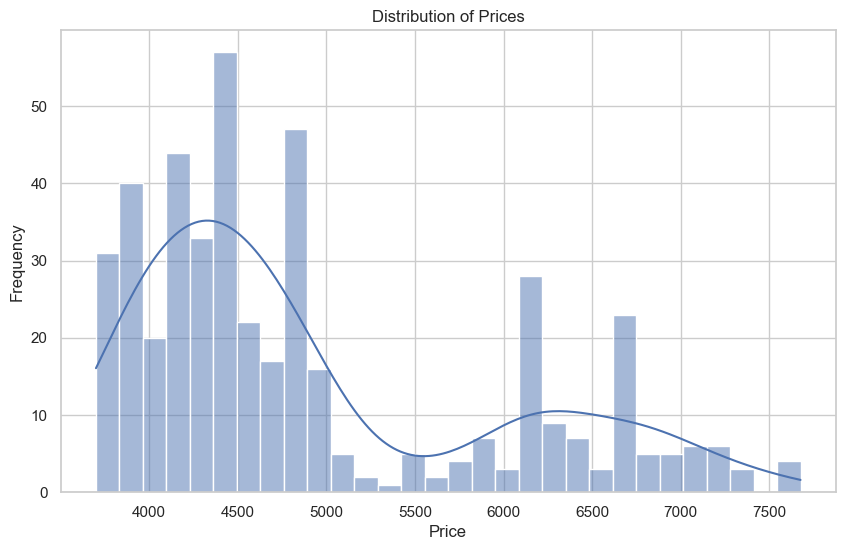

In [21]:
# Exploratory Data Analysis
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create covid_flag for data in 2020
df['covid_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2020 else 0)

# Create war_flag for data in 2022
df['war_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2022 else 0)

# Display the updated dataframe
df[['Date', 'covid_flag', 'war_flag']].head()
# Add a seasonality column based on the month
df['seasonality'] = df['Date'].dt.month % 12 // 3 + 1


# Display the updated dataframe with the new column
df[['Date', 'seasonality']].head()



,Date,seasonality
0,2015-03-27,2
1,2015-04-03,2
2,2015-04-10,2
3,2015-04-17,2
4,2015-04-24,2


In [23]:
from lightgbm import LGBMRegressor

In [24]:
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Initialize the starting point for the loop
current_date = pd.Timestamp('2023-05-05')
horizon = 32  # Number of weeks to extrapolate

# Loop until the end of December 2023
while current_date <= pd.Timestamp('2023-12-31'):
    data_2022_2023 = df[df['Date'] < current_date]
    for i in range (0, horizon):
        # Use 20-day moving averages for extrapolation
        forecasted_values = {}
        for column in ['Price_diff', 'volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                   'WZ1 Comdty', 'YW1 Comdty', 'max_temp', 'precipitation', 'avg_temp', 'min_temp']:
            if len(data_2022_2023[column]) >= 20:
                forecasted_values[column] = data_2022_2023[column].rolling(window=100).mean().iloc[-1]
            else:
                forecasted_values[column] = data_2022_2023[column].mean()

        # Create a new row with extrapolated data
        new_row = {
            'Date': current_date + timedelta(weeks=i),
            'volume': forecasted_values['volume'],
            'open_price': forecasted_values['open_price'],
            'USDZAR Curncy': forecasted_values['USDZAR Curncy'],
            'W 1 Comdty': forecasted_values['W 1 Comdty'],
            'W 2 Comdty': forecasted_values['W 2 Comdty'],
            'WZ1 Comdty': forecasted_values['WZ1 Comdty'],
            'YW1 Comdty': forecasted_values['YW1 Comdty'],
            'Price_diff': forecasted_values['Price_diff'],
            'year_month': (current_date + timedelta(weeks=i)).year * 100 + (current_date + timedelta(weeks=i)).month,
            'max_temp': forecasted_values['max_temp'],
            'precipitation': forecasted_values['precipitation'],
            'avg_temp': forecasted_values['avg_temp'],
            'min_temp': forecasted_values['min_temp'],
            'active_flag': 0,
            'covid_flag': 0,
            'war_flag': 0,
            'day': 'Friday',
            'seasonality': (current_date + timedelta(weeks=i)).month % 12 // 3 + 1
        }
        # Append the new row to the dataframe
        data_2022_2023 = pd.concat([data_2022_2023, pd.DataFrame([new_row])], ignore_index=True)
    print(f"Extrapolated data until {current_date + timedelta(weeks=horizon)}")
    print(data_2022_2023.tail(32))
    # Prepare the data for training
    features = ['volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                'WZ1 Comdty', 'YW1 Comdty', 'Price_diff', 'max_temp', 'precipitation', 
                'avg_temp', 'min_temp']
    target = 'Price'
    X_train = df[df['Date'] <= current_date][features].astype(float)
    y_train = df[df['Date'] <= current_date][target].astype(float)
    X_test = data_2022_2023[data_2022_2023['Date'] > current_date][features].astype(float)
    y_test = df[df['Date'] > current_date][target].astype(float)
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform both train and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train the Linear Regression model
    lr_model = LinearRegression()

    # Drop NaN values from training data
    print(X_train.isnull().sum())
    print(y_train.isnull().sum())

    # Train the Linear Regression model
    lr_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = lr_model.predict(X_test)
    print(len(y_pred))
    print(len(y_test))  
    
    horizon_array = np.arange(1, horizon + 1)
    # Ensure the lengths of y_pred and horizon_array match
    if len(y_pred) != len(horizon_array):
        horizon_array = horizon_array[:len(y_pred)]

    # Create a DataFrame for predictions
    prediction_current_date = pd.DataFrame({
        'Date': X_test.index,
        'Predicted_Price': y_pred,
        'Horizon': horizon_array
    })
    prediction_current_date = pd.DataFrame({'Date': X_test.index, 'Predicted_Price': y_pred, 'Horizon':horizon_array })
    current_date_str = current_date.strftime('%Y-%m-%d')
    prediction_current_date.to_csv(f'predictions_{current_date_str}.csv', index=False)
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
    current_date += timedelta(weeks=1)
    horizon -= 1
    

Extrapolated data until 2023-12-15 00:00:00
          Date  Price       volume   open_price  USDZAR Curncy  W 1 Comdty  \
423 2023-05-05    NaN   949.220000  6364.790000      16.264033  788.095000   
424 2023-05-12    NaN   958.112200  6380.137900      16.292357  789.098450   
425 2023-05-19    NaN   966.053322  6395.889279      16.318118  790.181935   
426 2023-05-26    NaN   974.593855  6411.268172      16.337790  791.456254   
427 2023-06-02    NaN   982.859794  6425.880854      16.359702  793.000816   
428 2023-06-09    NaN   988.958392  6440.319662      16.380790  794.473325   
429 2023-06-16    NaN   997.777976  6455.102859      16.402416  796.333058   
430 2023-06-23    NaN  1002.725755  6469.723887      16.422133  797.371388   
431 2023-06-30    NaN  1004.793013  6484.121126      16.437851  798.505102   
432 2023-07-07    NaN  1006.920943  6497.972337      16.456211  799.452653   
433 2023-07-14    NaN  1009.270152  6511.252061      16.474465  800.257180   
434 2023-07-21    Na

ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by StandardScaler.

In [25]:
import os
# Define the directory where the prediction CSV files are stored
predictions_dir = r'./'  # Replace with the actual directory path if different

# List all CSV files in the directory
csv_files = [file for file in os.listdir(predictions_dir) if file.startswith('predictions_') and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
predictions_list = []
# Extract the date from the file name and add it as a new column
for file in csv_files:
    file_date = file.split('_')[1].split('.')[0]  # Extract the date part from the file name
    df_new = pd.read_csv(os.path.join(predictions_dir, file))
    df_new['File_Date'] = file_date  # Add the extracted date as a new column
    predictions_list.append(df_new)

# Concatenate all DataFrames into a single DataFrame
all_predictions = pd.concat(predictions_list, ignore_index=True)

# Display the combined DataFrame
print(all_predictions.head())
print(f"Total predictions loaded: {len(all_predictions)}")


   Date  Predicted_Price  Horizon   File_Date
0   424      6397.347435        1  2023-05-05
1   425      6413.218770        2  2023-05-05
2   426      6428.745946        3  2023-05-05
3   427      6443.529397        4  2023-05-05
4   428      6458.124424        5  2023-05-05
Total predictions loaded: 496


In [26]:
# Convert 'File_Date' to datetime format
all_predictions['File_Date'] = pd.to_datetime(all_predictions['File_Date'])

# Calculate the prediction date by adding the horizon in weeks
all_predictions['prediction_date'] = all_predictions['File_Date'] + pd.to_timedelta(all_predictions['Horizon'], unit='W')

# Display the updated DataFrame
print(all_predictions.head())

   Date  Predicted_Price  Horizon  File_Date prediction_date
0   424      6397.347435        1 2023-05-05      2023-05-12
1   425      6413.218770        2 2023-05-05      2023-05-19
2   426      6428.745946        3 2023-05-05      2023-05-26
3   427      6443.529397        4 2023-05-05      2023-06-02
4   428      6458.124424        5 2023-05-05      2023-06-09


In [27]:
all_predictions.drop(columns=['Date'], inplace=True)
all_predictions.rename(columns={'prediction_date': 'Date'}, inplace=True)

In [28]:
# Ensure the 'Date' column in both DataFrames is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'], errors='coerce')

# Convert the 'Date' columns to string format for matching
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
all_predictions['Date'] = all_predictions['Date'].dt.strftime('%Y-%m-%d')

# Merge the DataFrames on the 'Date' column
merged_predictions = all_predictions.merge(df[['Date', 'Price']], on='Date', how='left')

# Display the merged DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price
0      6397.347435        1 2023-05-05  2023-05-12  6546.0
1      6413.218770        2 2023-05-05  2023-05-19  6530.0
2      6428.745946        3 2023-05-05  2023-05-26  6356.0
3      6443.529397        4 2023-05-05  2023-06-02  6346.0
4      6458.124424        5 2023-05-05  2023-06-09  6296.0


In [29]:
# Map the 'File_Date' to the corresponding 'Price' from the 'df' DataFrame
merged_predictions['Trained_Price'] = merged_predictions['File_Date'].dt.strftime('%Y-%m-%d').map(
    df.set_index('Date')['Price']
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price
0      6397.347435        1 2023-05-05  2023-05-12  6546.0         6383.0
1      6413.218770        2 2023-05-05  2023-05-19  6530.0         6383.0
2      6428.745946        3 2023-05-05  2023-05-26  6356.0         6383.0
3      6443.529397        4 2023-05-05  2023-06-02  6346.0         6383.0
4      6458.124424        5 2023-05-05  2023-06-09  6296.0         6383.0


In [30]:
# Calculate MAPE
merged_predictions['mape'] = abs(merged_predictions['Predicted_Price'] - merged_predictions['Price']) / merged_predictions['Price']

# Calculate Directional Accuracy
merged_predictions['dir_acc'] = merged_predictions.apply(
    lambda row: 1 if (
        (row['Price'] > row['Trained_Price'] and row['Predicted_Price'] > row['Trained_Price']) or
        (row['Price'] < row['Trained_Price'] and row['Predicted_Price'] < row['Trained_Price']) or
        (row['Price'] == row['Trained_Price'])
    ) else 0, axis=1
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price  \
0      6397.347435        1 2023-05-05  2023-05-12  6546.0         6383.0   
1      6413.218770        2 2023-05-05  2023-05-19  6530.0         6383.0   
2      6428.745946        3 2023-05-05  2023-05-26  6356.0         6383.0   
3      6443.529397        4 2023-05-05  2023-06-02  6346.0         6383.0   
4      6458.124424        5 2023-05-05  2023-06-09  6296.0         6383.0   

       mape  dir_acc  
0  0.022709        1  
1  0.017884        1  
2  0.011445        0  
3  0.015369        0  
4  0.025750        0  


In [16]:
# Group by 'Horizon' and calculate the sum and count of 'dir_acc' values
horizon_dir_acc_stats = merged_predictions.groupby('Horizon')['dir_acc'].agg(['sum', 'count'])

# Calculate the percentage
horizon_dir_acc_stats['percentage'] = (horizon_dir_acc_stats['sum'] / horizon_dir_acc_stats['count']) * 100

# Display the result
print(horizon_dir_acc_stats)

         sum  count  percentage
Horizon                        
1         15     31   48.387097
2         13     30   43.333333
3         12     29   41.379310
4          9     28   32.142857
5          8     27   29.629630
6          7     26   26.923077
7         10     25   40.000000
8          5     24   20.833333
9          5     23   21.739130
10         6     22   27.272727
11         4     21   19.047619
12         2     20   10.000000
13         3     19   15.789474
14         2     18   11.111111
15         2     17   11.764706
16         0     16    0.000000
17         0     15    0.000000
18         0     14    0.000000
19         0     13    0.000000
20         0     12    0.000000
21         0     11    0.000000
22         0     10    0.000000
23         0      9    0.000000
24         0      8    0.000000
25         0      7    0.000000
26         0      6    0.000000
27         0      5    0.000000
28         0      4    0.000000
29         0      3    0.000000
30      

In [31]:
sum_dir_acc = merged_predictions['dir_acc'].sum()
print(sum_dir_acc)

103
